# Introduction to Deep Learning -  Sign language digits recognition
This is notebook is an attempt at creating a neural network capable of differentiating between sign language digits
## 1. Setup
Firstly imports needed for the project as well as some aesthetic touches to the future plots.

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True, figsize=(12, 6))
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10,
       grid=True)
plt.rc('grid', alpha=1)

## 2. Deleting corrupted files
To filter badly-encoded images the first 10 bytes of each file were checked to see if they contain a string "JFIF" (but in byte format, not unicode). Lack of such string might indicate that the file is corrupted as all ".JPG" files should have such string (in byte format) at the beginning of the file.

In [2]:
num_skipped = 0
folder_names = [f"{i}" for i in range(10)]
files_to_delete = []
for folder_name in folder_names:
       folder_path = os.path.join("data/dataset", folder_name)
       for file_name in os.listdir(folder_path):
              file_path = os.path.join(folder_path, file_name)
              try:
                     file_obj = open(file_path, "rb")
                     is_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
              finally:
                     file_obj.close()

              if not is_jfif:
                     num_skipped += 1
                     files_to_delete.append(file_path)
                     # os.remove(file_path)
print(f"{num_skipped} files to delete")
print(files_to_delete)

False
False
False
3 files to delete
['data/dataset/7/IMG_5874.JPG', 'data/dataset/7/IMG_5935.JPG', 'data/dataset/7/IMG_5978.JPG']


## 3. Data preprocessing
Data is split into three chunks. This is because a lot of data is needed for training, some data is needed for validation of said training, on per epoch basis, and finally some data is needed for final evaluation of the model after all the training is done and all parameters are picked. It was decided that 80% of the data will be used for training and the rest will be split evenly between validation data and training data

In [3]:
image_size = (100, 100)
batch_size = 32

train_ds = image_dataset_from_directory(
       'data/dataset',
       validation_split=0.2,
       subset='training',
       seed=1337,
       image_size=image_size,
       batch_size=batch_size,
       labels="inferred",
       label_mode="categorical",
)

val_ds = image_dataset_from_directory(
       'data/dataset',
       validation_split=0.2,
       subset='validation',
       seed=1337,
       image_size=image_size,
       batch_size=batch_size,
       labels="inferred",
       label_mode="categorical",
)

val_ds_size = len(val_ds)
test_ds_size = val_ds_size // 2
test_ds = val_ds.take(test_ds_size)
val_ds = val_ds.skip(test_ds_size)

Found 2062 files belonging to 10 classes.
Using 1650 files for training.
Found 2062 files belonging to 10 classes.
Using 412 files for validation.


2022-01-16 21:51:31.478355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 21:51:31.526956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 21:51:31.527187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 21:51:31.528697: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

A sample of the data can be seen below.

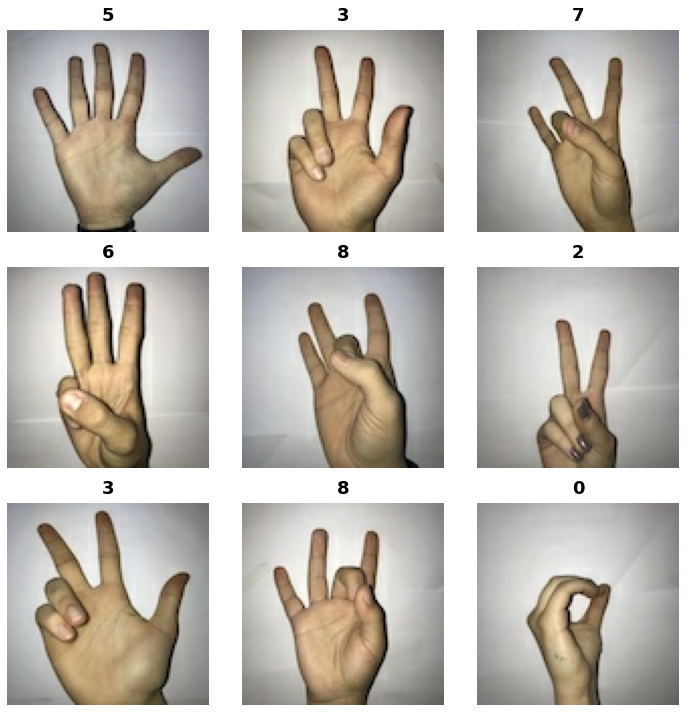

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
       labels_tensor = tf.argmax(labels, axis=1)
       for i in range(9):
              ax = plt.subplot(3, 3, i + 1)
              plt.title(int(labels_tensor[i]))
              plt.imshow(images[i].numpy().astype('uint8'))
              plt.axis("off")

For the model to learn to recognize the actual sign language digits some randomness needs to be implemented. Without it the model might simply learn to recognize specific way of showing a digit. The data was collected in such a way that the hands base is in the bottom halve of the image and fingers are in the top halve. Further more all (or almost all) images contain someones right hand. This is not how digits are shown in real world. Someone might use his or her left hand or maybe with a hand rotated 90 degrees  slight rotation.

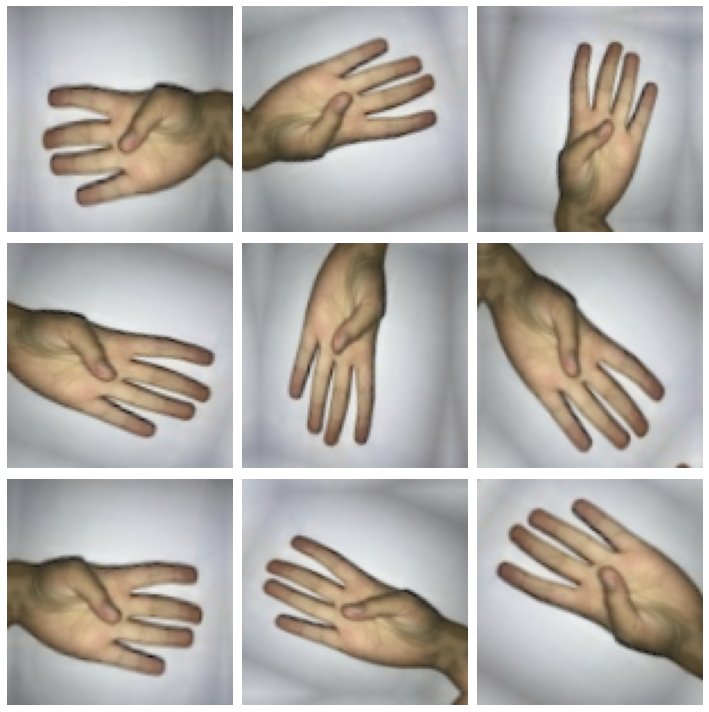

In [6]:
data_augmentation = models.Sequential(
       [
              layers.RandomFlip("horizontal"),
              layers.RandomFlip("vertical"),
              layers.RandomRotation(0.3),
              layers.RandomZoom(-0.2, 0.2),
       ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
       for i in range(9):
              augmented_images = data_augmentation(images)
              ax = plt.subplot(3, 3, i + 1)
              plt.imshow(augmented_images[0].numpy().astype("uint8"))
              plt.axis("off")

In [7]:
# Adding buffer for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 4. Creating the model
Since this is this authors first attempt at deep learning two models were used. First model was built from scratch. Second one is a smaller version of Xception model and is used for comparison of performance, to see what results could have been achieved.

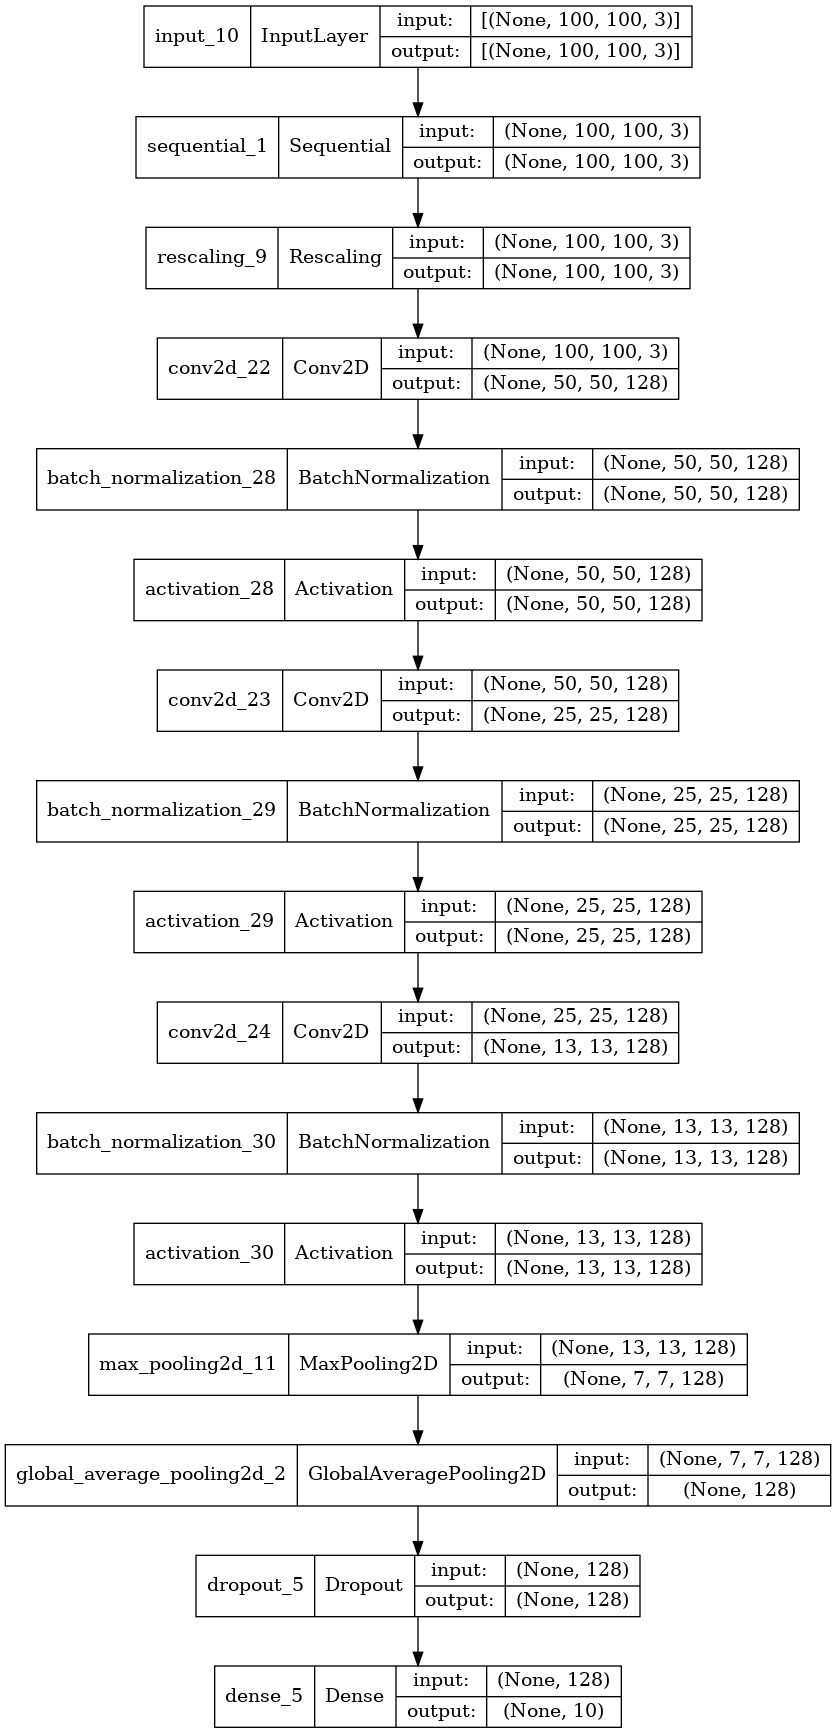

In [24]:
def make_own_model(input_shape):
       inputs = keras.Input(shape=input_shape)
       # Image augmentation block
       x = data_augmentation(inputs)

       # Entry block
       x = layers.Rescaling(1.0 / 255)(x)
       x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

       x = layers.GlobalAveragePooling2D()(x)
       x = layers.Dropout(0.5)(x)

       outputs = layers.Dense(10, activation="softmax")(x)

       return keras.Model(inputs, outputs)


own_model = make_own_model(input_shape=image_size + (3,))
keras.utils.plot_model(own_model, show_shapes=True)

In [30]:
def train_model(model):
      epochs = 100

      callbacks = [
              keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=100,
                                           restore_best_weights=True)
       ]
      model.compile(
              optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"],
      )

      return model.fit(
              train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
      )


def evaluate_model(history):
       loss = history.history['loss']
       accuracy = history.history['accuracy']
       val_loss = history.history['val_loss']
       val_accuracy = history.history['val_accuracy']
       x_axis = [i for i in range(len(loss))]


       fig, sub = plt.subplots(1, 2)
       sub[0].plot(x_axis, loss, 'y', label="Training loss")
       sub[0].plot(x_axis, val_loss, 'b', label="Validation loss")
       sub[0].set_title("Training and validation loss")
       sub[0].set_xlabel("Epochs")
       sub[0].set_ylabel("Loss")
       sub[0].legend()

       sub[1].plot(x_axis, accuracy, 'y', label="Training accuracy")
       sub[1].plot(x_axis, val_accuracy, 'b', label="Validation accuracy")
       sub[1].set_title("Training and validation accuracy")
       sub[1].set_xlabel("Epochs")
       sub[1].set_ylabel("Loss")
       sub[1].legend()
       fig.show()

In [32]:
own_history = train_model(own_model)

52/52 [==============================] - 1s 10ms/step - loss: 0.9076 - accuracy: 0.6721 - val_loss: 11.6958 - val_accuracy: 0.1091
Epoch 13/100
52/52 [==============================] - 1s 10ms/step - loss: 0.9641 - accuracy: 0.6382 - val_loss: 16.4134 - val_accuracy: 0.1727
Epoch 14/100
52/52 [==============================] - 1s 10ms/step - loss: 0.9364 - accuracy: 0.6497 - val_loss: 3.8104 - val_accuracy: 0.2818
Epoch 15/100
52/52 [==============================] - 1s 16ms/step - loss: 0.9204 - accuracy: 0.6733 - val_loss: 3.4759 - val_accuracy: 0.2636
Epoch 16/100
52/52 [==============================] - 1s 11ms/step - loss: 0.9255 - accuracy: 0.6630 - val_loss: 7.9032 - val_accuracy: 0.2045
Epoch 17/100
52/52 [==============================] - 1s 12ms/step - loss: 0.9247 - accuracy: 0.6770 - val_loss: 11.8910 - val_accuracy: 0.1409
Epoch 18/100
52/52 [==============================] - 1s 10ms/step - loss: 0.9431 - accuracy: 0.6648 - val_loss: 10.8540 - val_accuracy: 0.1409
Epoch 19

/tmp/ipykernel_11709/627801886.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


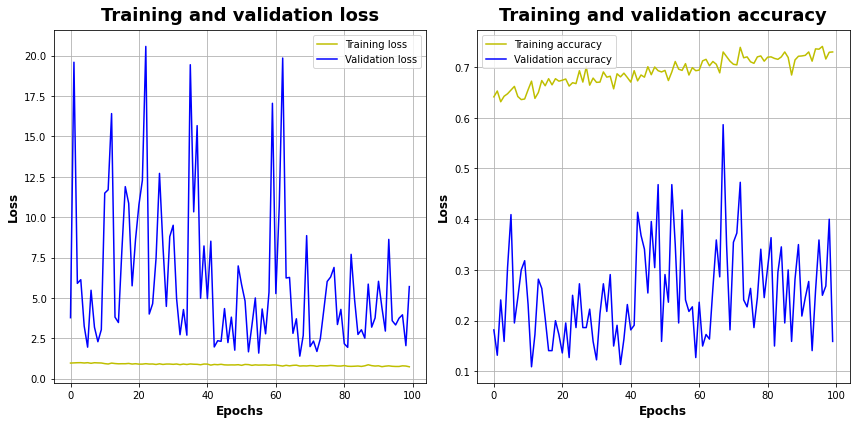

In [33]:
evaluate_model(own_history)

In [34]:
own_model.evaluate(test_ds)

6/6 [==============================] - 0s 5ms/step - loss: 4.9118 - accuracy: 0.1823


[4.911844730377197, 0.1822916716337204]

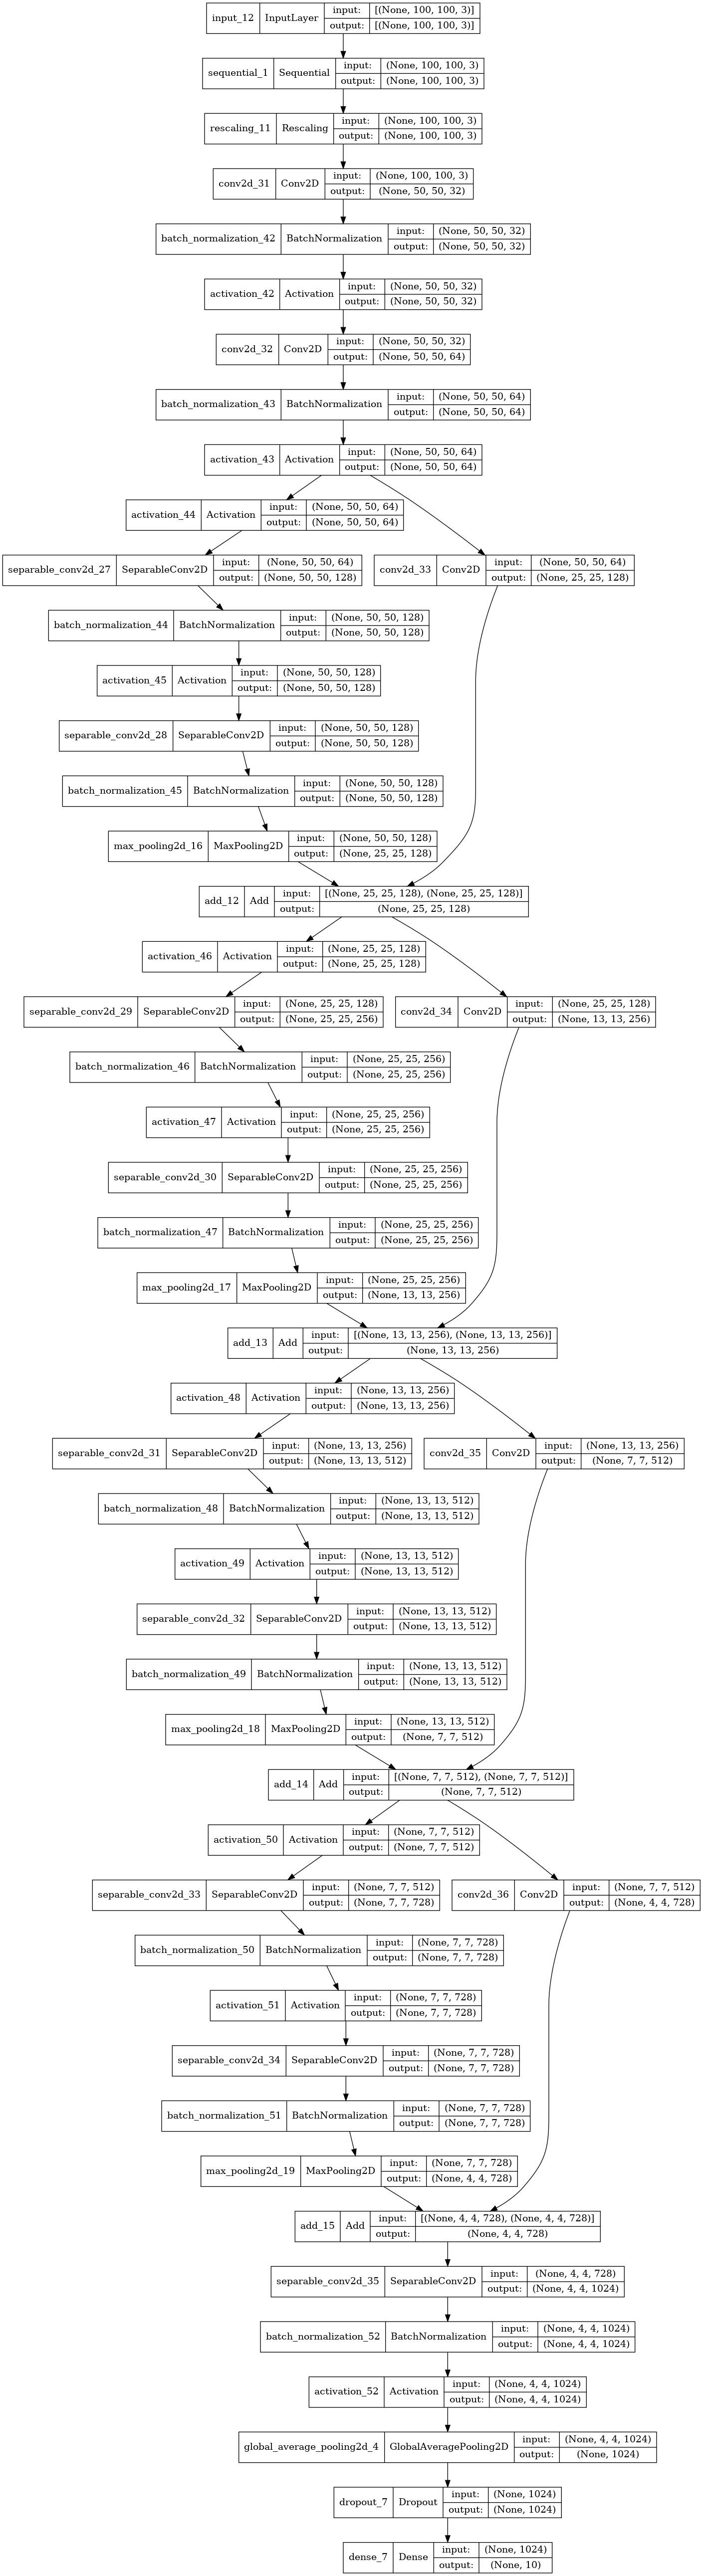

In [28]:
def make_xception_model(input_shape):
       inputs = keras.Input(shape=input_shape)
       # Image augmentation block
       x = data_augmentation(inputs)

       # Entry block
       x = layers.Rescaling(1.0 / 255)(x)
       x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.Conv2D(64, 3, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       previous_block_activation = x  # Set aside residual

       for size in [128, 256, 512, 728]:
              x = layers.Activation("relu")(x)
              x = layers.SeparableConv2D(size, 3, padding="same")(x)
              x = layers.BatchNormalization()(x)

              x = layers.Activation("relu")(x)
              x = layers.SeparableConv2D(size, 3, padding="same")(x)
              x = layers.BatchNormalization()(x)

              x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

              # Project residual
              residual = layers.Conv2D(size, 1, strides=2, padding="same")(
                     previous_block_activation
              )
              x = layers.add([x, residual])  # Add back residual
              previous_block_activation = x  # Set aside next residual

       x = layers.SeparableConv2D(1024, 3, padding="same")(x)
       x = layers.BatchNormalization()(x)
       x = layers.Activation("relu")(x)

       x = layers.GlobalAveragePooling2D()(x)


       x = layers.Dropout(0.5)(x)
       outputs = layers.Dense(10, activation="softmax")(x)
       return keras.Model(inputs, outputs)


xception_model = make_xception_model(input_shape=image_size + (3,))  # todo why + (3,)
keras.utils.plot_model(xception_model, show_shapes=True)

In [22]:
xception_history = train_model(xception_model)

Epoch 1/100
52/52 [==============================] - 5s 55ms/step - loss: 1.9720 - accuracy: 0.2891 - val_loss: 2.2963 - val_accuracy: 0.1227
Epoch 2/100
52/52 [==============================] - 2s 41ms/step - loss: 1.1768 - accuracy: 0.5855 - val_loss: 2.3117 - val_accuracy: 0.1182
Epoch 3/100
52/52 [==============================] - 2s 43ms/step - loss: 0.8622 - accuracy: 0.6976 - val_loss: 2.4536 - val_accuracy: 0.1000
Epoch 4/100
52/52 [==============================] - 2s 42ms/step - loss: 0.6265 - accuracy: 0.7776 - val_loss: 2.8875 - val_accuracy: 0.1136
Epoch 5/100
52/52 [==============================] - 2s 43ms/step - loss: 0.5292 - accuracy: 0.8170 - val_loss: 3.0828 - val_accuracy: 0.0955
Epoch 6/100
52/52 [==============================] - 2s 44ms/step - loss: 0.4203 - accuracy: 0.8491 - val_loss: 4.2949 - val_accuracy: 0.1182
Epoch 7/100
52/52 [==============================] - 2s 44ms/step - loss: 0.4085 - accuracy: 0.8648 - val_loss: 4.8026 - val_accuracy: 0.0727
Epoch 

In [ ]:
# img = keras.preprocessing.image.load_img(
#        "data/dataset/7/IMG_1135.JPG", target_size=image_size
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis
#
# predictions = model.predict(img_array)
# scores = list(predictions[0])
# print(scores.index(max(scores)) == 7)

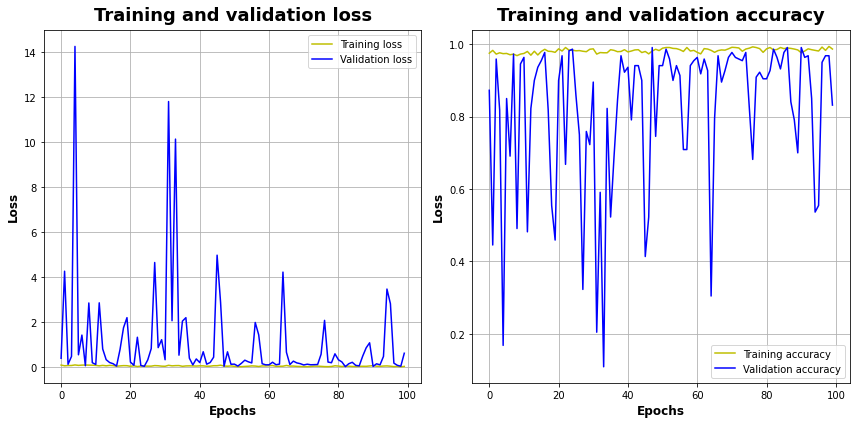

In [19]:
evaluate_model(xception_history)

In [20]:
xception_model.evaluate(test_ds)

6/6 [==============================] - 0s 6ms/step - loss: 0.3411 - accuracy: 0.8854


[0.34105005860328674, 0.8854166865348816]

## 6. Conclusions